In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# Load dataset
df = pd.read_csv('american_bankruptcy.csv')
# Rename columns X1 to X18 to actual financial terms
df.rename(columns={
    'X1': 'Current assets',
    'X2': 'Cost of goods sold',
    'X3': 'Depreciation and amortization',
    'X4': 'EBITDA',
    'X5': 'Inventory',
    'X6': 'Net Income',
    'X7': 'Total Receivables',
    'X8': 'Market Value',
    'X9': 'Net Sales',
    'X10': 'Total Assets',
    'X11': 'Total Long-term Debt',
    'X12': 'EBIT',
    'X13': 'Gross Profit',
    'X14': 'Total Current Liabilities',
    'X15': 'Retained Earnings',
    'X16': 'Total Revenue',
    'X17': 'Total Liabilities',
    'X18': 'Total Operating Expenses'
}, inplace=True)

# Inspect data to ensure columns have been renamed correctly
print(df.info())
print(df.describe())
# Calculate Debt-to-Equity Ratio (Total Liabilities / Total Assets)
df['Debt_Equity_Ratio'] = df['Total Liabilities'] / df['Total Assets']

# Calculate the Altman Z-Score
df['Altman_Z_Score'] = (1.2 * (df['Current assets'] - df['Total Current Liabilities']) / df['Total Assets'] +
                        1.4 * (df['Retained Earnings'] / df['Total Assets']) +
                        3.3 * (df['EBIT'] / df['Total Assets']) +
                        0.6 * (df['Market Value'] / df['Total Liabilities']) +
                        1.0 * (df['Net Sales'] / df['Total Assets']))

# Check the new columns to confirm
print(df[['Debt_Equity_Ratio', 'Altman_Z_Score']].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_name                   78682 non-null  object 
 1   status_label                   78682 non-null  object 
 2   year                           78682 non-null  int64  
 3   Current assets                 78682 non-null  float64
 4   Cost of goods sold             78682 non-null  float64
 5   Depreciation and amortization  78682 non-null  float64
 6   EBITDA                         78682 non-null  float64
 7   Inventory                      78682 non-null  float64
 8   Net Income                     78682 non-null  float64
 9   Total Receivables              78682 non-null  float64
 10  Market Value                   78682 non-null  float64
 11  Net Sales                      78682 non-null  float64
 12  Total Assets                   78682 non-null 

In [15]:
# Convert 'status_label' to numerical values
# 'alive' -> 0 (Not Bankrupt), 'failed' -> 1 (Bankrupt)
df['status_label'] = df['status_label'].apply(lambda x: 1 if x == 'failed' else 0)

# Check the conversion
print(df['status_label'].value_counts())


status_label
0    73462
1     5220
Name: count, dtype: int64


In [17]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Separate features and target variable (including the new financial metrics)
X = df.drop(columns=['company_name', 'status_label', 'year'])  # Drop unnecessary columns
y = df['status_label']  # Target variable
# 2. Split data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Handle class imbalance using Borderline-SMOTE (with new features)
borderline_smote = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train, y_train)

# 4. Scale the features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# Check the shape of the balanced training data
print("Balanced training set shape:", X_train_balanced.shape)
print("Original test set shape:", X_test.shape)


Balanced training set shape: (117538, 20)
Original test set shape: (15737, 20)


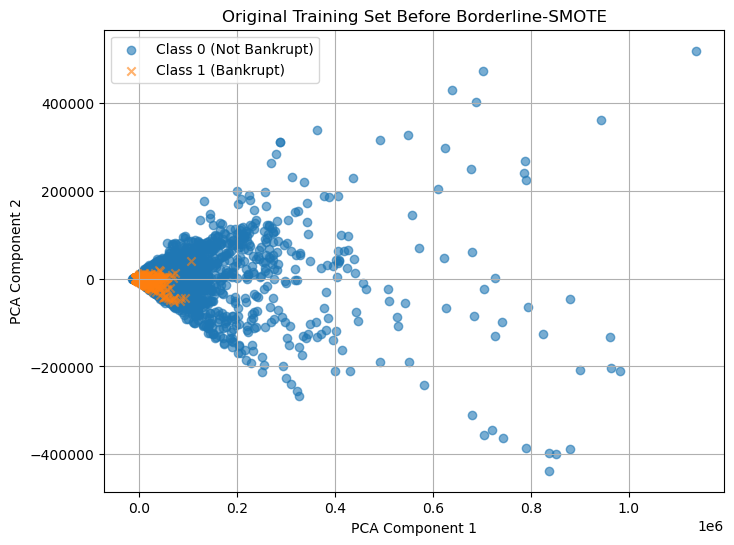

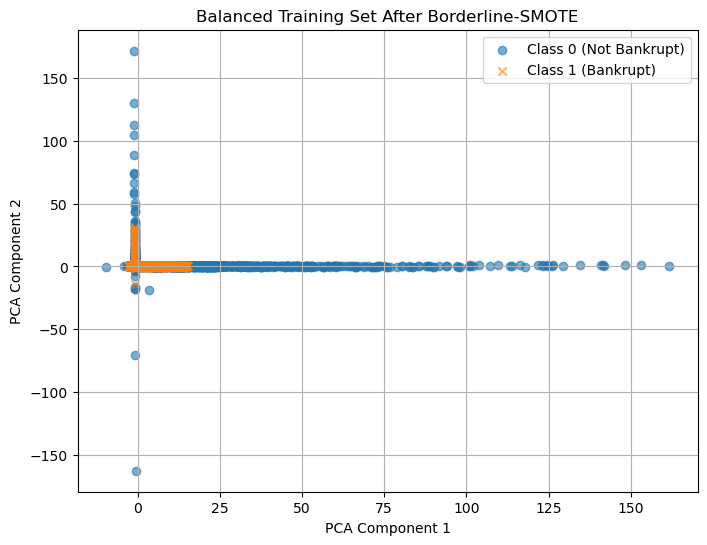

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to visualize the data
def visualize_data(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)  # Reduce to 2 components for 2D plotting
    
    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], label="Class 0 (Not Bankrupt)", alpha=0.6)
    plt.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], label="Class 1 (Bankrupt)", alpha=0.6, marker='x')
    
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize original training set before Borderline-SMOTE
visualize_data(X_train, y_train, title="Original Training Set Before Borderline-SMOTE")

# Visualize the balanced training set after applying Borderline-SMOTE
visualize_data(X_train_balanced, y_train_balanced, title="Balanced Training Set After Borderline-SMOTE")


In [20]:
df.head(5)

,company_name,status_label,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,...,Total Long-term Debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses,Debt_Equity_Ratio,Altman_Z_Score
0,C_1,0,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302,0.541814,3.196587
1,C_1,0,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888,0.515267,3.109968
2,C_1,0,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514,0.563172,2.226949
3,C_1,0,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592,0.570377,1.709901
4,C_1,0,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467,0.574669,2.240159
